![Alt text](https://imgur.com/orZWHly.png=80)
source: @allison_horst https://github.com/allisonhorst/penguins

You have been asked to support a team of researchers who have been collecting data about penguins in Antartica! The data is available in csv-Format as `penguins.csv`

**Origin of this data** : Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

**The dataset consists of 5 columns.**

Column | Description
--- | ---
culmen_length_mm | culmen length (mm)
culmen_depth_mm | culmen depth (mm)
flipper_length_mm | flipper length (mm)
body_mass_g | body mass (g)
sex | penguin sex

Unfortunately, they have not been able to record the species of penguin, but they know that there are **at least three** species that are native to the region: **Adelie**, **Chinstrap**, and **Gentoo**.  Your task is to apply your data science skills to help them identify groups in the dataset!

In [1]:
# Import all required libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Define a global random seed.
RANDOM_SEED = 42

# Set the seed for Python's random module, NumPy.
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [2]:
# Load the dataset.
penguins_df = pd.read_csv("penguins.csv")

# Display the first few rows of the dataset for inspection.
print("First 5 rows of the dataset:", end="\n\n")
display(penguins_df.head(5))

# Display the shape of the dataset (rows, columns).
print(f"\nDataset shape: {penguins_df.shape}", end="\n\n")

First 5 rows of the dataset:



,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,36.7,19.3,193.0,3450.0,FEMALE
4,39.3,20.6,190.0,3650.0,MALE



Dataset shape: (332, 5)



**1. Exploratory Data Analysis**

In [3]:
# Basic dataset information: summary of columns, non-null counts, and data types
print("Dataset Info:", end="\n\n")
penguins_df.info()

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   332 non-null    float64
 1   culmen_depth_mm    332 non-null    float64
 2   flipper_length_mm  332 non-null    float64
 3   body_mass_g        332 non-null    float64
 4   sex                332 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.1+ KB


In [4]:
# Display the number of unique values in each column.
print("Unique values per column:", end="\n\n")
print(penguins_df.nunique())

Unique values per column:

culmen_length_mm     163
culmen_depth_mm       79
flipper_length_mm     54
body_mass_g           93
sex                    2
dtype: int64


In [5]:
# Display basic statistical description of numeric features.
print("Descriptive statistics for numeric features:", end="\n\n")
penguins_df.describe()

Descriptive statistics for numeric features:



,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,332.000000,332.000000,332.000000,332.000000
mean,44.021084,17.153012,200.975904,4206.475904
std,5.452462,1.960275,14.035971,806.361278
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.700000,17.300000,197.000000,4025.000000
75%,48.625000,18.700000,213.000000,4781.250000
max,59.600000,21.500000,231.000000,6300.000000


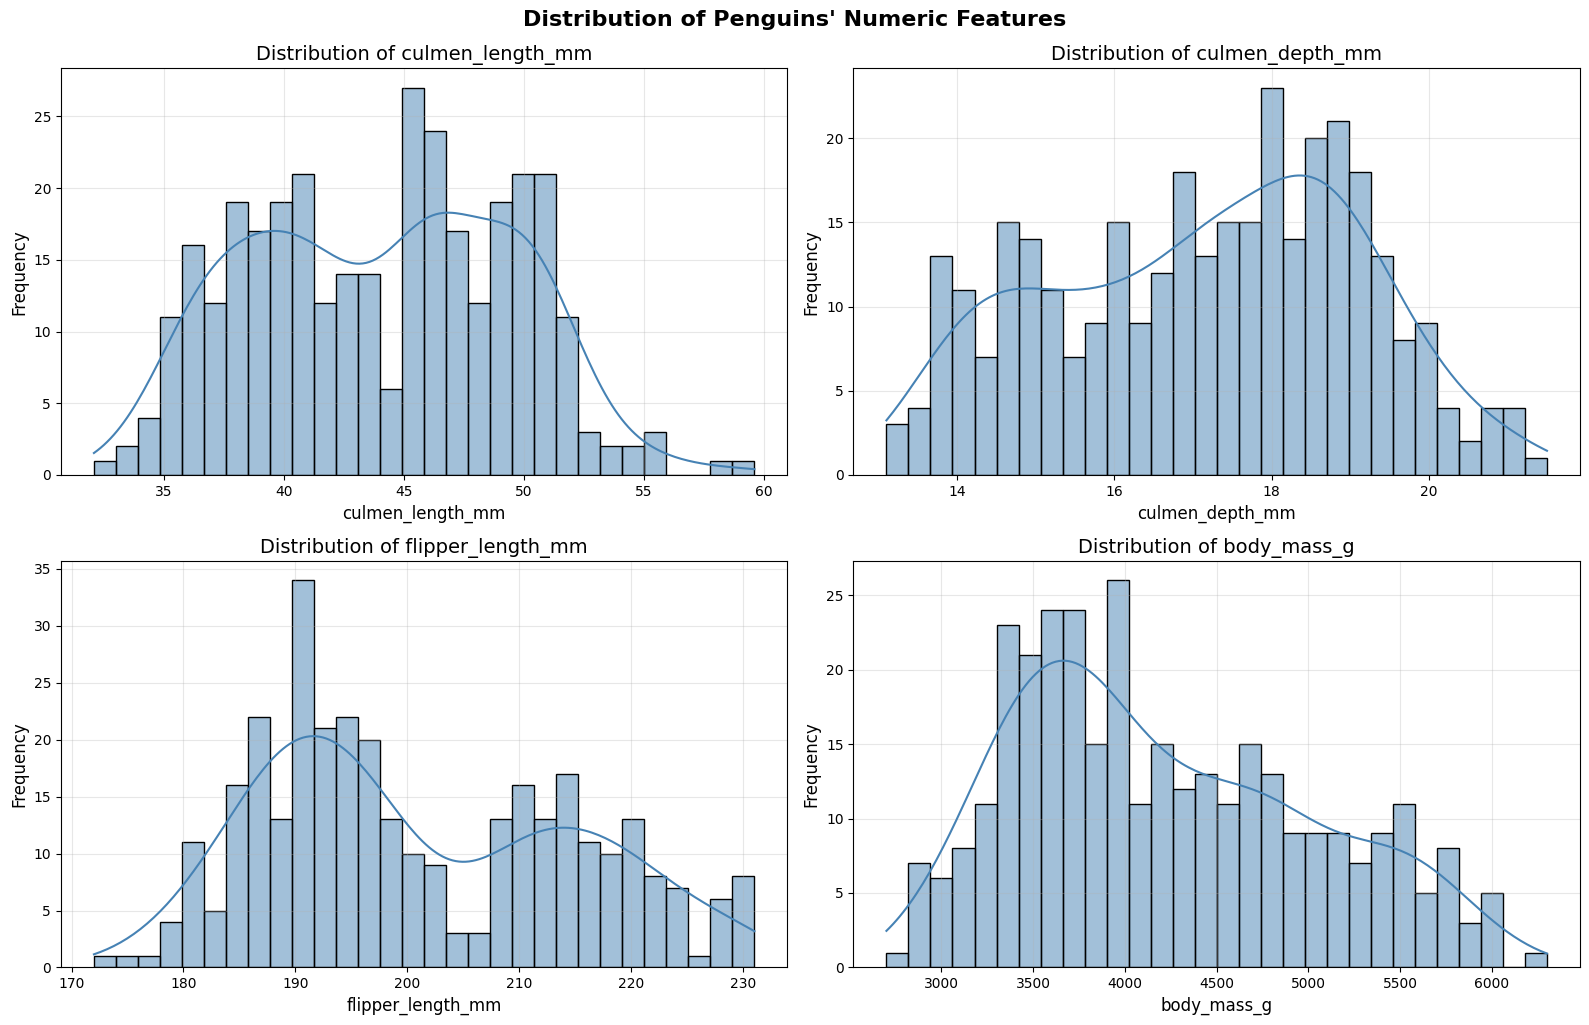

In [6]:
# Visualize the distribution of numeric features.
plt.figure(figsize=(16, 10))
numeric_columns = penguins_df.select_dtypes(include=[np.number]).columns
for i, column in enumerate(numeric_columns, start=1):
    plt.subplot(2, 2, i)
    sns.histplot(penguins_df[column], kde=True, bins=30, color="steelblue", edgecolor="black")
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.suptitle("Distribution of Penguins' Numeric Features", fontsize=16, fontweight="bold", y=1.02)
plt.show()

In [7]:
# Check for missing values in the dataset.
print("Missing values in the dataset:", end="\n\n")
print(penguins_df.isna().sum())

Missing values in the dataset:

culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64


In [8]:
# Function to detect outliers using the IQR method.
def detect_outliers(column: str):
    """
    Detect outliers in a numeric column using the IQR method.

    Parameters:
        column (str): Name of the column to analyze.

    Returns:
        tuple: (number of outliers, lower bound, upper bound)
    """
    Q1 = penguins_df[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = penguins_df[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = penguins_df[(penguins_df[column] < lower_bound) | (penguins_df[column] > upper_bound)]
    return outliers.shape[0], lower_bound, upper_bound

# Detect outliers for all numeric columns.
numeric_columns = penguins_df.select_dtypes(include=[np.number]).columns
outlier_analysis = {metric: detect_outliers(metric) for metric in numeric_columns}

# Display outlier counts and bounds for each metric.
print("Outlier analysis:", end="\n\n")
for metric, (count, lower, upper) in outlier_analysis.items():
    print(f"{metric}: {count} outliers (Lower Bound: {lower}, Upper Bound: {upper})")

Outlier analysis:

culmen_length_mm: 0 outliers (Lower Bound: 25.8125, Upper Bound: 62.3125)
culmen_depth_mm: 0 outliers (Lower Bound: 10.95, Upper Bound: 23.349999999999998)
flipper_length_mm: 0 outliers (Lower Bound: 155.5, Upper Bound: 247.5)
body_mass_g: 0 outliers (Lower Bound: 1703.125, Upper Bound: 6628.125)


**2) Data Preprocessing**

In [9]:
# Identify numeric and categorical features in the dataset.
numeric_features = penguins_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = penguins_df.select_dtypes(include=["object", "category"]).columns.tolist()

# Pipeline for preprocessing numeric features
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())  # Scale numeric features using StandardScaler.
])

# Pipeline for preprocessing categorical features
categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first", dtype=int))  # Apply One-Hot Encoding for categorical variables.
])

# Combine the numeric and categorical preprocessors into a ColumnTransformer.
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),         # Apply numeric transformer to numeric features.
        ("cat", categorical_transformer, categorical_features)  # Apply categorical transformer to categorical features.
    ],
    remainder="drop"  # Drop any columns not specified in the transformers.
)

# Combine preprocessing and PCA into a pipeline.
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),  # Apply preprocessing.
    ("pca", PCA(n_components=None))  # Apply PCA.
])

# Fit the pipeline to the dataset.
pipeline.fit(penguins_df)

# Transform the data.
penguins_transformed = pipeline.transform(penguins_df)

# Extract explained variance ratio and determine optimal number of components.
explained_variance_ratio = pipeline.named_steps["pca"].explained_variance_ratio_
n_components = sum(explained_variance_ratio > 0.1) # Consider any component with an explained variance ratio above 10% as a suitable component.

# Update PCA with the optimal number of components and refit the pipeline.
pipeline.set_params(pca__n_components=n_components)
penguins_PCA = pipeline.fit_transform(penguins_df)

# Display the results.
print("Explained variance ratios by components:", explained_variance_ratio)
print(f"Number of components retained: {n_components}")

Explained variance ratios by components: [0.65040396 0.21135765 0.09441677 0.02708833 0.01673329]
Number of components retained: 2


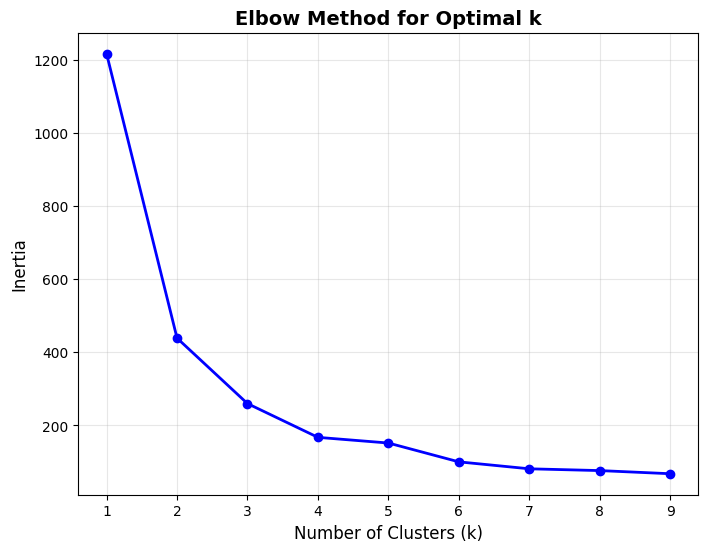

In [10]:
# Compute the inertia for different values of k (1 to 9) for the Elbow Method.
inertias = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
    kmeans.fit(penguins_PCA)
    inertias.append(kmeans.inertia_)

# Plot the Elbow Curve.
plt.figure(figsize=(8, 6))
plt.plot(range(1, 10), inertias, marker="o", linestyle="-", linewidth=2, color="b")
plt.title("Elbow Method for Optimal k", fontsize=14, fontweight="bold")
plt.xlabel("Number of Clusters (k)", fontsize=12)
plt.ylabel("Inertia", fontsize=12)
plt.xticks(range(1, 10))
plt.grid(alpha=0.3)
plt.show()

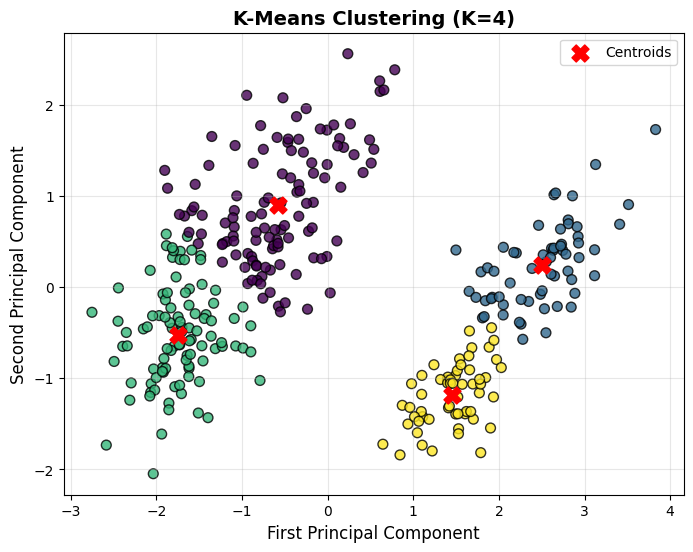

In [11]:
# Define the optimal number of clusters.
n_clusters = 4

# Apply K-Means clustering.
kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED).fit(penguins_PCA)

# Retrieve the cluster labels assigned to each data point by the KMeans algorithm.
labels = kmeans.labels_

# Plot the clustering results.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    penguins_PCA[:, 0], penguins_PCA[:, 1],
    c=labels, cmap="viridis", s=50, edgecolor="k", alpha=0.8
)
plt.xlabel("First Principal Component", fontsize=12)
plt.ylabel("Second Principal Component", fontsize=12)
plt.title(f'K-Means Clustering (K={n_clusters})', fontsize=14, fontweight="bold")
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s=150, c="red", marker="X", label="Centroids")
plt.legend(loc="best", fontsize=10)
plt.grid(alpha=0.3)
plt.show()

In [12]:
# Add the cluster labels to the original DataFrame.
penguins_df["cluster"] = kmeans.labels_

# Compute the mean of numeric features for each cluster.
stat_penguins = penguins_df.groupby("cluster")[numeric_columns].mean()

# Display the resulting statistical DataFrame.
print("Cluster-wise statistical mean summary of numeric features:", end="\n\n")
print(stat_penguins)

Cluster-wise statistical mean summary of numeric features:

         culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
cluster                                                                   
0               45.445217        18.916522         195.886957  3964.130435
1               49.548387        15.706452         221.451613  5479.435484
2               38.042857        17.702041         187.204082  3415.051020
3               45.414035        14.224561         212.649123  4671.491228


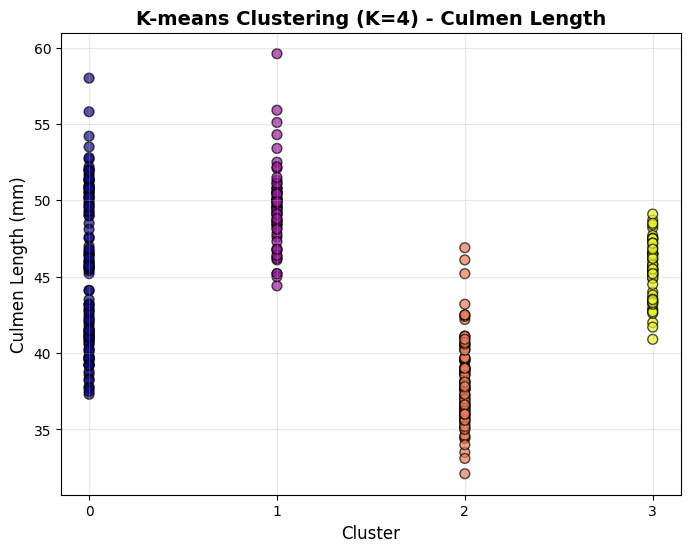

In [13]:
# Scatter plot of cluster labels vs culmen_length_mm
plt.figure(figsize=(8, 6))
plt.scatter(
    penguins_df["cluster"],  # Cluster labels
    penguins_df["culmen_length_mm"],  # A numeric feature to plot
    c=kmeans.labels_,  # Color points by cluster labels
    cmap="plasma",     # Use a color map for differentiation.
    s=50,              # Set marker size.
    edgecolor="k",     # Add black edges for better visualization.
    alpha=0.7          # Slight transparency for clarity
)

# Add labels and title.
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Culmen Length (mm)", fontsize=12)
plt.xticks(range(int(penguins_df["cluster"].min()), int(penguins_df["cluster"].max()) + 1))
plt.title(f'K-means Clustering (K={n_clusters}) - Culmen Length', fontsize=14, fontweight="bold")

# Add grid for better visualization.
plt.grid(alpha=0.3)

# Display the plot.
plt.show()